--- FASE 1: CARGANDO ARTEFACTOS DE IA ---
-> Modelo y traductores cargados exitosamente.
Clases de Pieza conocidas: [np.str_('Pieza_Eje'), np.str_('Pieza_Impulsor')]
Clases de Estado conocidas: [np.str_('corrosion'), np.str_('desgaste'), np.str_('optimo'), np.str_('ruptura')]

--- FASE 2: ANÁLISIS DE PREDICCIÓN INDIVIDUAL ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


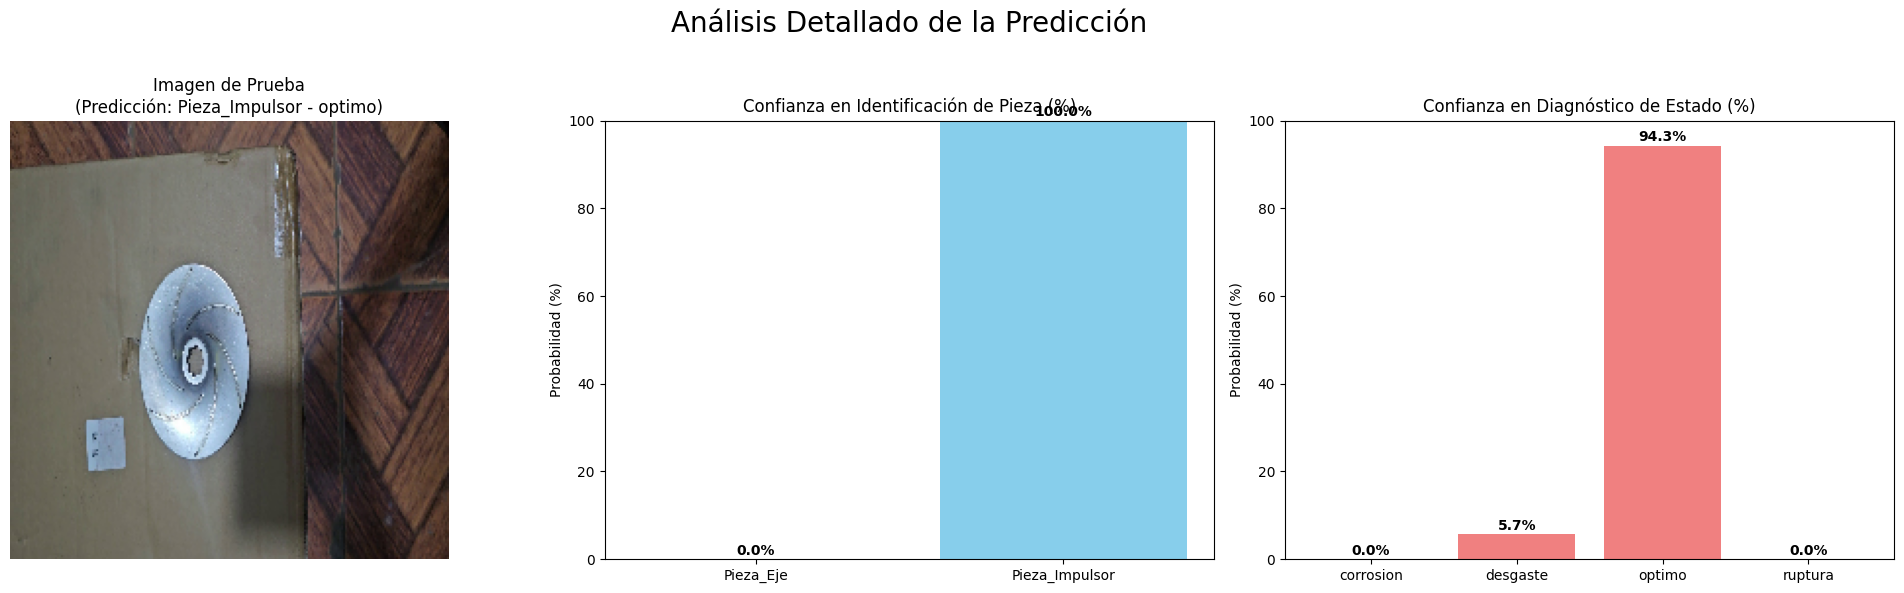


--- FASE 3: ANÁLISIS DE RENDIMIENTO GLOBAL (SOBRE DATOS DE VALIDACIÓN) ---
Realizando predicciones sobre 1600 imágenes de validación...
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step


--- Reporte de Rendimiento: IDENTIFICACIÓN DE PIEZA ---
                precision    recall  f1-score   support

     Pieza_Eje       1.00      1.00      1.00       400
Pieza_Impulsor       1.00      1.00      1.00      1200

      accuracy                           1.00      1600
     macro avg       1.00      1.00      1.00      1600
  weighted avg       1.00      1.00      1.00      1600



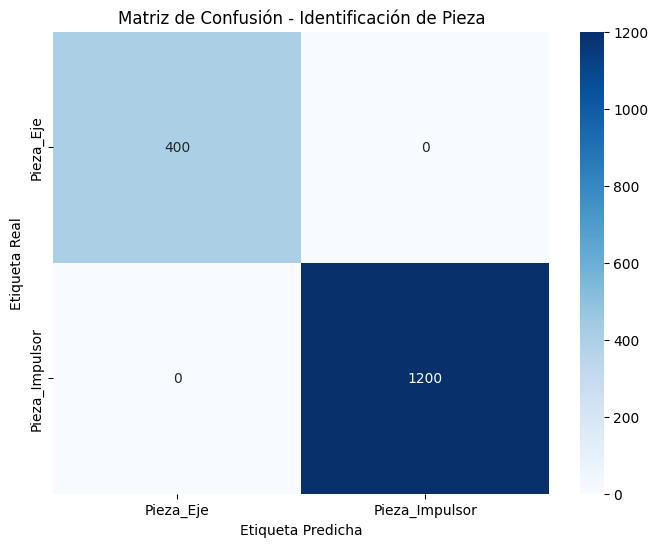



--- Reporte de Rendimiento: DIAGNÓSTICO DE ESTADO ---
              precision    recall  f1-score   support

   corrosion       0.92      0.99      0.95       158
    desgaste       0.95      0.98      0.97       486
      optimo       0.99      0.97      0.98       609
     ruptura       0.98      0.93      0.95       347

    accuracy                           0.97      1600
   macro avg       0.96      0.97      0.96      1600
weighted avg       0.97      0.97      0.97      1600



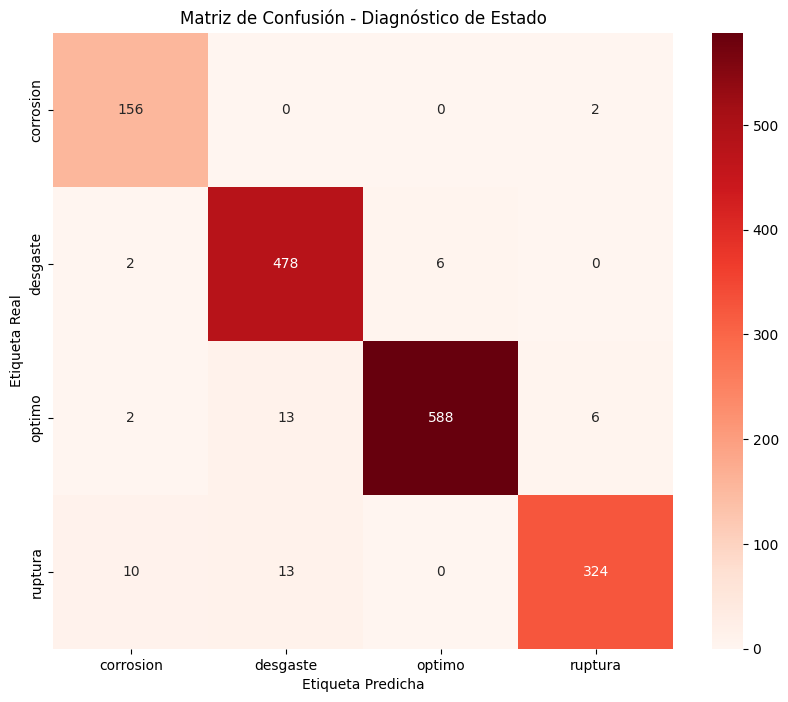

In [4]:
# ===================================================================
# PASO 0: IMPORTACIÓN DE LIBRERÍAS
# ===================================================================
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# ===================================================================
# PASO 1: CARGA DE ARTEFACTOS (MODELO Y TRADUCTORES)
# ===================================================================
print("--- FASE 1: CARGANDO ARTEFACTOS DE IA ---")

# Nombres de los archivos guardados
MODEL_FILENAME = "modelo_diagnostico_v1.keras"
PIEZA_ENCODER_FILENAME = "pieza_encoder.joblib"
ESTADO_ENCODER_FILENAME = "estado_encoder.joblib"

# Verificación de que los archivos existen
if not all(os.path.exists(f) for f in [MODEL_FILENAME, PIEZA_ENCODER_FILENAME, ESTADO_ENCODER_FILENAME]):
    raise RuntimeError("¡Error! Faltan archivos de modelo o encoders. Asegúrate de ejecutar primero el notebook 'entrenar_y_guardar.ipynb'.")

# Carga de los artefactos
model = tf.keras.models.load_model(MODEL_FILENAME)
pieza_encoder = joblib.load(PIEZA_ENCODER_FILENAME)
estado_encoder = joblib.load(ESTADO_ENCODER_FILENAME)

print("-> Modelo y traductores cargados exitosamente.")
print(f"Clases de Pieza conocidas: {list(pieza_encoder.classes_)}")
print(f"Clases de Estado conocidas: {list(estado_encoder.classes_)}")

IMG_SIZE = (160, 160) # Debe ser el mismo tamaño usado en el entrenamiento

# ===================================================================
# PASO 2: ANÁLISIS DE PREDICCIÓN EN UNA IMAGEN INDIVIDUAL
# ===================================================================
print("\n--- FASE 2: ANÁLISIS DE PREDICCIÓN INDIVIDUAL ---")

# --- ¡ATENCIÓN! MODIFICA ESTA LÍNEA ---
# Cambia esta ruta para probar con diferentes imágenes de tu dataset.
# Es ideal usar imágenes de la carpeta de validación o nuevas.
path_imagen_prueba = "Dataset/Pieza_Impulsor/optimo/impulsor_optimo_78.jpg"

if not os.path.exists(path_imagen_prueba):
    raise FileNotFoundError(f"La imagen de prueba no se encontró en: {path_imagen_prueba}")

# Función para cargar y preprocesar la imagen
def load_and_preprocess_for_prediction(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    original_img = tf.image.resize(img, (224, 224)) # Un poco más grande para mejor visualización
    
    img_resized = tf.image.resize(img, IMG_SIZE)
    img_expanded = tf.expand_dims(img_resized, axis=0)
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_expanded)
    return original_img, img_preprocessed

# Preparamos la imagen
original_image, processed_image = load_and_preprocess_for_prediction(path_imagen_prueba)

# Realizamos la predicción
predictions = model.predict(processed_image)
pred_pieza_prob = predictions[0][0]
pred_estado_prob = predictions[1][0]

# Decodificamos el resultado más probable
label_pieza_predicha = pieza_encoder.inverse_transform([np.argmax(pred_pieza_prob)])[0]
label_estado_predicho = estado_encoder.inverse_transform([np.argmax(pred_estado_prob)])[0]

# --- Visualización con Gráficos y Análisis ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Análisis Detallado de la Predicción', fontsize=20)

# 1. Mostrar la imagen de prueba
axes[0].imshow(original_image.numpy().astype("uint8"))
axes[0].set_title(f"Imagen de Prueba\n(Predicción: {label_pieza_predicha} - {label_estado_predicho})")
axes[0].axis("off")

# 2. Gráfico de barras para la predicción de PIEZA
axes[1].bar(pieza_encoder.classes_, pred_pieza_prob * 100, color='skyblue')
axes[1].set_title('Confianza en Identificación de Pieza (%)')
axes[1].set_ylabel('Probabilidad (%)')
axes[1].set_ylim(0, 100)
for i, v in enumerate(pred_pieza_prob * 100):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

# 3. Gráfico de barras para la predicción de ESTADO
axes[2].bar(estado_encoder.classes_, pred_estado_prob * 100, color='lightcoral')
axes[2].set_title('Confianza en Diagnóstico de Estado (%)')
axes[2].set_ylabel('Probabilidad (%)')
axes[2].set_ylim(0, 100)
for i, v in enumerate(pred_estado_prob * 100):
    axes[2].text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ===================================================================
# PASO 3: ANÁLISIS GLOBAL SOBRE EL CONJUNTO DE VALIDACIÓN
# ===================================================================
print("\n--- FASE 3: ANÁLISIS DE RENDIMIENTO GLOBAL (SOBRE DATOS DE VALIDACIÓN) ---")

# Recreamos el dataset de validación para hacer las predicciones
# (Necesitamos las rutas y etiquetas que se crearon en el notebook de entrenamiento)
# Para no repetir todo el código, lo ideal sería guardar estas listas.
# Por simplicidad aquí, recreamos la división.
image_paths = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("Dataset")) for f in fn if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
pieza_labels_str = [os.path.basename(os.path.dirname(os.path.dirname(p))) for p in image_paths]

# Usamos los encoders ya cargados
y_piezas = pieza_encoder.transform(pieza_labels_str)
y_estados = estado_encoder.transform(labels)

_, X_val_paths, _, y_val_piezas, _, y_val_estados = train_test_split(
    image_paths, y_piezas, y_estados, test_size=0.2, random_state=42, stratify=pieza_labels_str
)

# Hacemos predicciones para todo el conjunto de validación
print(f"Realizando predicciones sobre {len(X_val_paths)} imágenes de validación...")
val_images = np.array([load_and_preprocess_for_prediction(p)[1][0] for p in X_val_paths])
val_predictions = model.predict(val_images)

pred_val_piezas = np.argmax(val_predictions[0], axis=1)
pred_val_estados = np.argmax(val_predictions[1], axis=1)

# --- Matriz de Confusión y Reporte para PIEZA ---
print("\n\n--- Reporte de Rendimiento: IDENTIFICACIÓN DE PIEZA ---")
print(classification_report(y_val_piezas, pred_val_piezas, target_names=pieza_encoder.classes_))

cm_piezas = confusion_matrix(y_val_piezas, pred_val_piezas)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_piezas, annot=True, fmt='d', cmap='Blues', xticklabels=pieza_encoder.classes_, yticklabels=pieza_encoder.classes_)
plt.title('Matriz de Confusión - Identificación de Pieza')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


# --- Matriz de Confusión y Reporte para ESTADO ---
print("\n\n--- Reporte de Rendimiento: DIAGNÓSTICO DE ESTADO ---")
# *** CORRECCIÓN FINAL AQUÍ ***
# Cambiamos 'zero_division_report' por 'zero_division', que es el nombre
# correcto del argumento en las versiones nuevas de scikit-learn.
print(classification_report(y_val_estados, pred_val_estados, target_names=estado_encoder.classes_, zero_division=0))

cm_estados = confusion_matrix(y_val_estados, pred_val_estados)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_estados, annot=True, fmt='d', cmap='Reds', xticklabels=estado_encoder.classes_, yticklabels=estado_encoder.classes_)
plt.title('Matriz de Confusión - Diagnóstico de Estado')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()
